## Final Project Submission

Please fill out:
* Student name: Brian Tracy
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('data\kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Get baseline data for simple regression

In [2]:
baseline_df = data.select_dtypes(include='number').copy()
baseline_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,770,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,1530,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,2310,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,1020,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,400000.0,3,2.50,1600,2388,2.0,1600,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
baseline_df.isna().sum()

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
sqft_above          0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
baseline_df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1948.0        1
1951.0        1
1971.0        1
1934.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64

Convert all the NaNs in yr_renovated to 0.0.
Will consider binning and/or generating binary column later for renovated or not.

In [5]:
baseline_df.fillna(0.0, inplace=True)

In [6]:
baseline_df.isna().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
sqft_above       0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   sqft_above     21597 non-null  int64  
 8   yr_built       21597 non-null  int64  
 9   yr_renovated   21597 non-null  float64
 10  zipcode        21597 non-null  int64  
 11  lat            21597 non-null  float64
 12  long           21597 non-null  float64
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 2.5 MB


In [8]:
X = baseline_df.drop('price', axis=1)
y = baseline_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [11]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


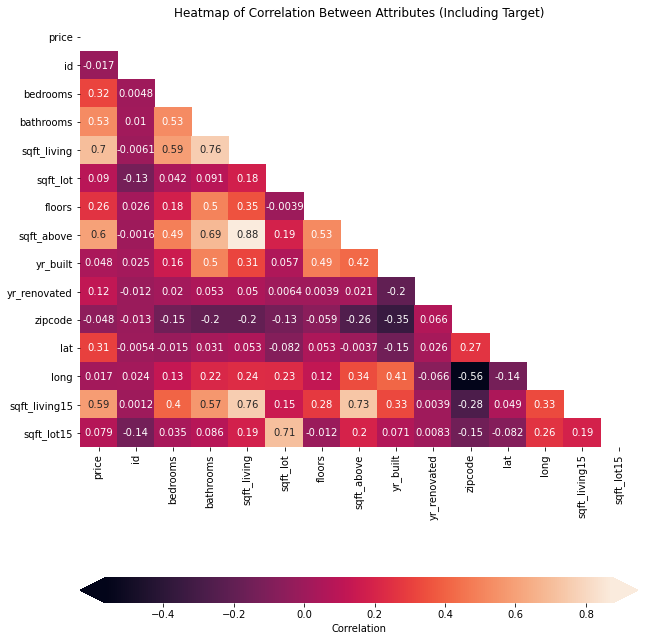

In [10]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 12))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [13]:
linreg = LinearRegression().fit(X_train, y_train)

In [14]:
y_hat = linreg.predict(X_test)

In [15]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=linreg,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:", baseline_scores["train_score"].mean())
print("Test score:", baseline_scores["test_score"].mean())

Train score: 0.6290901571831893
Test score: 0.6250003875281944
